# Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Read Solar Energy Production Dataset

In [5]:
data = pd.read_csv('F:\APU\FYP\Dataset\Cleaned_data\solar_production_dataset.csv')

data.head()

,Country,Date,Value,Daylight,Temperature,GHI,DNI
0,Australia,2023-03-01,4055.6634,734.69403,26.204160,894897.94,693884.56
1,Australia,2023-02-01,4466.4801,778.22370,27.318323,997130.10,756902.75
2,Australia,2023-01-01,4967.0119,812.18915,27.128540,1009778.60,739408.44
3,Australia,2022-12-01,5179.1465,822.62040,26.521873,1087540.60,817223.80
4,Australia,2022-11-01,4548.5315,801.65320,23.784800,1055200.00,791037.10


## Extract Data for each country

In [6]:
countries = data['Country'].unique()

solar_production_data = {}

# use loc() function to select data from a DataFrame based on specified row and column labels or conditions.
# Iterate over the countries
for country in countries:
    # Filter the data for the current country and 'solar' product
    country_energy_production = data.loc[
        (data['Country'] == country), ['Date', 'Value', 'Daylight', 'Temperature', 'GHI', 'DNI']
    ]
    
    # Store the filtered data in the dictionary
    solar_production_data[country] = country_energy_production.reset_index(drop=True)

solar_production_data['Brazil']

,Date,Value,Daylight,Temperature,GHI,DNI
0,2023-03-01,3229.6411,729.43024,25.151640,745227.60,477252.34
1,2023-02-01,3115.4989,746.79600,25.162394,792236.10,510204.60
2,2023-01-01,3079.7458,760.43445,24.790960,777342.60,487180.80
3,2022-12-01,2878.2354,764.79016,25.088167,782418.06,500598.03
4,2022-11-01,2570.8271,756.64110,24.932850,845781.90,576999.44
...,...,...,...,...,...,...
94,2015-05-01,2.6990,697.20416,24.321304,614931.94,389156.00
95,2015-04-01,3.2480,711.68700,25.133720,686429.06,432017.88
96,2015-03-01,3.1510,729.46410,25.190317,709770.06,421773.66
97,2015-02-01,2.4750,746.82355,25.475231,766134.70,470419.90


# Resample to daily data

In [7]:
# hypro_production_data
for country_data in solar_production_data:
    
    # set time as the index
    solar_production_data[country_data]['Date'] = pd.to_datetime(solar_production_data[country_data]['Date'])
    solar_production_data[country_data].set_index('Date', inplace=True)
    
    # divide the monthly statistical production value by the number of days 
    # of the month to get the avarage daily production value
    solar_production_data[country_data]['Value'] = (solar_production_data[country_data]['Value']/
                                                    solar_production_data[country_data].index.days_in_month)
    
    # resample the monthly index to daily and impute the missing value with linear interpolate method
    daily_data = solar_production_data[country_data].resample('D').interpolate('linear')
    solar_production_data[country_data] = daily_data
    
solar_production_data['Brazil']

,Value,Daylight,Temperature,GHI,DNI
Date,,,,,
2015-01-01,0.084290,760.447270,25.878698,842722.100000,562283.900000
2015-01-02,0.084423,760.007795,25.865683,840251.538710,559320.545161
2015-01-03,0.084555,759.568320,25.852668,837780.977419,556357.190323
2015-01-04,0.084687,759.128845,25.839653,835310.416129,553393.835484
2015-01-05,0.084820,758.689371,25.826638,832839.854839,550430.480645
...,...,...,...,...,...
2023-02-25,105.194235,731.911063,25.153176,751943.100000,481959.805714
2023-02-26,104.941169,731.290857,25.152792,750264.225000,480782.939286
2023-02-27,104.688103,730.670651,25.152408,748585.350000,479606.072857


# Model Building

### Split train and test data

In [8]:
data = solar_production_data['Brazil']

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date], data[split_date:]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

               Value    Daylight  Temperature            GHI            DNI
Date                                                                       
2015-01-01  0.084290  760.447270    25.878698  842722.100000  562283.900000
2015-01-02  0.084423  760.007795    25.865683  840251.538710  559320.545161
2015-01-03  0.084555  759.568320    25.852668  837780.977419  556357.190323
2015-01-04  0.084687  759.128845    25.839653  835310.416129  553393.835484
2015-01-05  0.084820  758.689371    25.826638  832839.854839  550430.480645
(2193, 5)

                Value    Daylight  Temperature            GHI            DNI
Date                                                                        
2021-01-01  36.595458  760.267640    25.401333  799212.200000  509042.780000
2021-01-02  36.454936  759.824368    25.392578  797770.735484  507726.251613
2021-01-03  36.314413  759.381095    25.383824  796329.270968  506409.723226
2021-01-04  36.173891  758.937823    25.375069  794887.806452  505093.19

## Univariate Model - ARIMA - Daily

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#### The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (0,2,0) 

#### Figure below show the result from R:
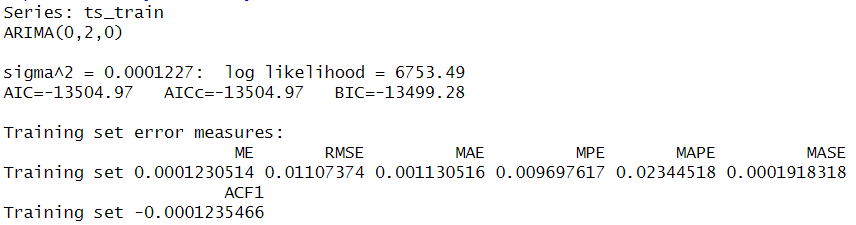

In [61]:
import rpy2.robjects as robjects
# Load the 'forecast' R package
robjects.r("library(forecast)")

# Load the ARIMA model
r_load = robjects.r['readRDS']
brz_solar_arima_model = r_load(r"F:\APU\FYP\SEM 2\Report Doc\R script\brz_solar_arima_model.rds")

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'forecast' was built under R version 4.1.3 



In [62]:
# Generate predictions
r_forecast = robjects.r['forecast']
predictions = r_forecast(brz_solar_arima_model, h=len(test))

# Evaluate the model performance
print("Mean Absolute Error: ", mean_absolute_error(predictions.rx('mean')[0], test['Value'].values))
mse = mean_squared_error(predictions.rx('mean')[0], test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  78.37791948716895
Mean Squared Error:  7818.595300879593
Root Mean Squared Error:  88.4228211542676


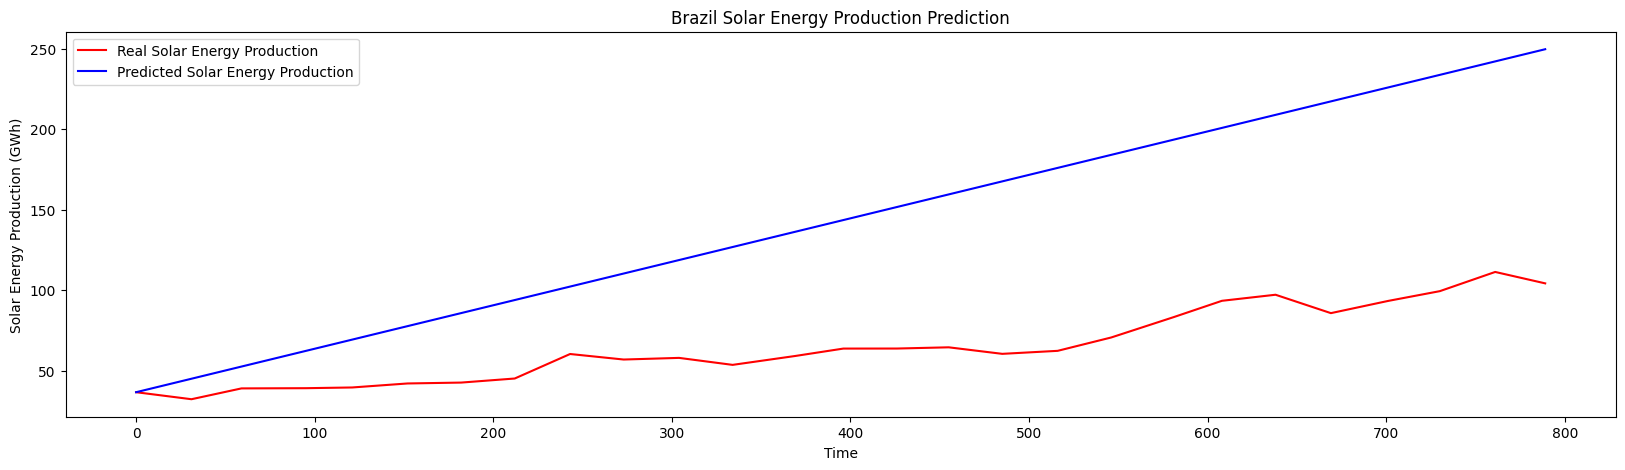

In [63]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Solar Energy Production')
plt.plot(predictions.rx('mean')[0], color = 'blue', label = 'Predicted Solar Energy Production')
plt.title('Brazil Solar Energy Production Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production (GWh)')
plt.legend()
plt.show()

## SVM - Univariate

In [73]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [112]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data
time_steps = 365  # Define the number of previous time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(1828, 365) (1828,)


In [113]:
# Build and Train the SVM Model
brz_daily_svr = SVR(kernel='linear',gamma=0.5, C=0.1, epsilon = 0.01) # Specify hyperparameters
brz_daily_svr.fit(x_train, y_train)

SVR(C=0.1, epsilon=0.01, gamma=0.5, kernel='linear')

In [114]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Solar Energy Production
svr_y_pred = brz_daily_svr.predict(x_test).reshape(-1,1)
svr_y_pred = scaler.inverse_transform(svr_y_pred)
print(y_pred.shape)

(790, 1)


In [115]:
print(inputs)

[[0.696618  ]
 [0.69767146]
 [0.69872493]
 ...
 [2.86472983]
 [2.85779957]
 [2.85086931]]


In [116]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(svr_y_pred, test['Value'].values))
mse = mean_squared_error(svr_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  0.9029642456381507
Mean Squared Error:  1.321792770876635
Root Mean Squared Error:  1.1496924679568163


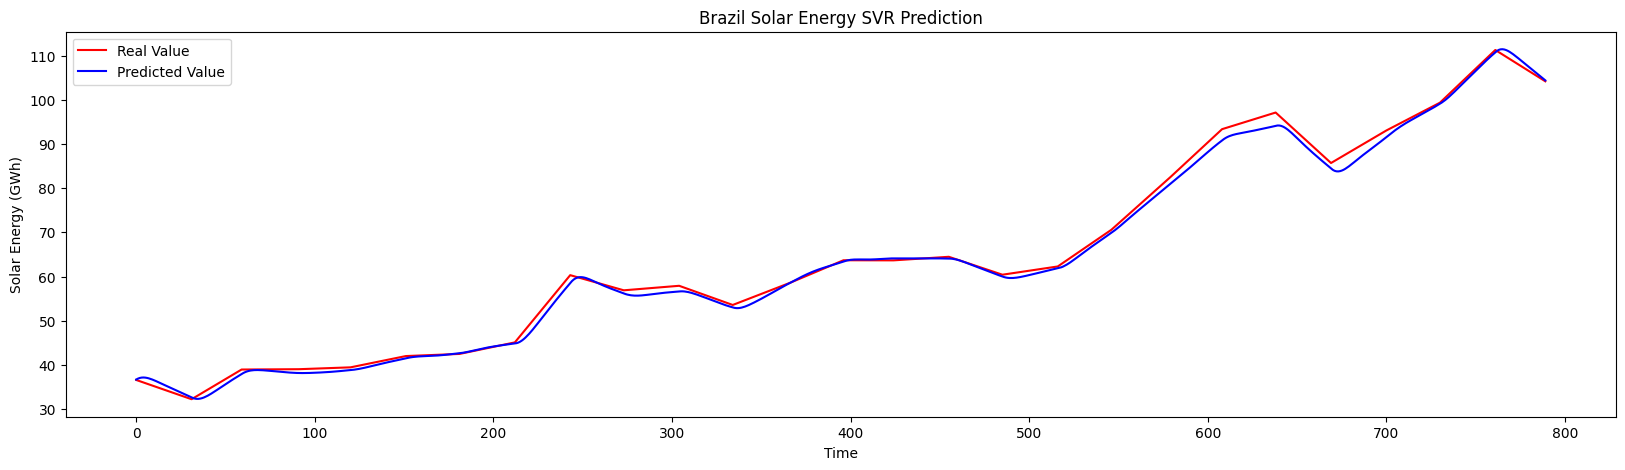

In [117]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(svr_y_pred, color='blue', label='Predicted Value')
plt.title('Brazil Solar Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

## Univariate GRU - Daily

In [104]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

In [105]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 365

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test['Value'].values, time_steps)

In [106]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Create the model
brz_daily_gru = Sequential()
brz_daily_gru.add(GRU(units=64, return_sequences=True, input_shape=(time_steps, 1)))
brz_daily_gru.add(GRU(units=64))
brz_daily_gru.add(Dense(1, activation='linear'))

brz_daily_gru.compile(optimizer='adam', loss='mean_squared_error')

In [107]:
brz_daily_gru.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
58/58 [==============================] - 325s 287ms/step - loss: 0.0101
Epoch 2/100
58/58 [==============================] - 17s 294ms/step - loss: 4.3505e-05
Epoch 3/100
58/58 [==============================] - 17s 293ms/step - loss: 3.0062e-05
Epoch 4/100
58/58 [==============================] - 16s 275ms/step - loss: 2.7371e-05
Epoch 5/100
58/58 [==============================] - 16s 280ms/step - loss: 2.6851e-05
Epoch 6/100
58/58 [==============================] - 17s 295ms/step - loss: 2.6093e-05
Epoch 7/100
58/58 [==============================] - 17s 293ms/step - loss: 2.3954e-05
Epoch 8/100
58/58 [==============================] - 16s 280ms/step - loss: 2.0544e-05
Epoch 9/100
58/58 [==============================] - 17s 288ms/step - loss: 1.9352e-05
Epoch 10/100
58/58 [==============================] - 15s 263ms/step - loss: 2.1192e-05
Epoch 11/100
58/58 [==============================] - 15s 268ms/step - loss: 2.1038e-05
Epoch 12/100
58/58 [========================

58/58 [==============================] - 11s 195ms/step - loss: 4.3156e-06
Epoch 95/100
58/58 [==============================] - 11s 191ms/step - loss: 5.0196e-06
Epoch 96/100
58/58 [==============================] - 11s 193ms/step - loss: 7.2688e-06
Epoch 97/100
58/58 [==============================] - 12s 203ms/step - loss: 4.0695e-06
Epoch 98/100
58/58 [==============================] - 11s 193ms/step - loss: 2.3430e-06
Epoch 99/100
58/58 [==============================] - 11s 189ms/step - loss: 2.1495e-05
Epoch 100/100
58/58 [==============================] - 11s 196ms/step - loss: 3.1575e-06


In [108]:
# Getting the predicted value
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
X_test = np.array(X_test)

gru_y_pred = brz_daily_gru.predict(X_test)
gru_y_pred = sc.inverse_transform(gru_y_pred)

25/25 [==============================] - 6s 58ms/step


In [109]:
print("Mean Absolute Error: ", mean_absolute_error(gru_y_pred, test['Value'].values))
mse = mean_squared_error(gru_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  1.997688089332568
Mean Squared Error:  9.060486015341219
Root Mean Squared Error:  3.0100641214667205


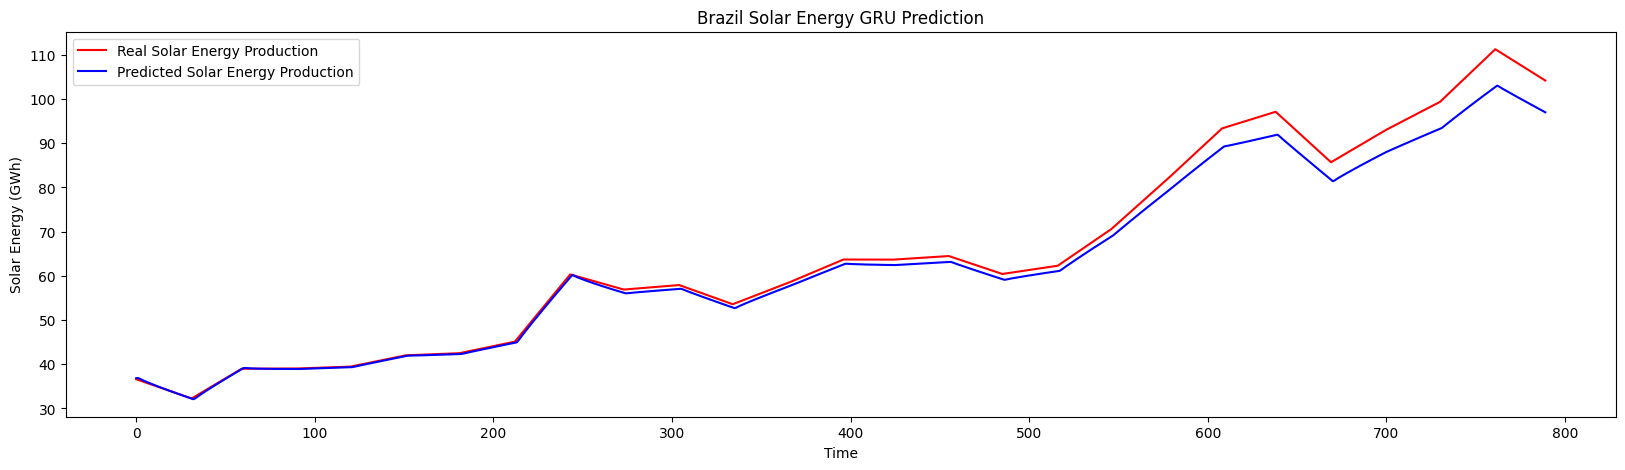

In [110]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Solar Energy Production')
plt.plot(gru_y_pred, color = 'blue', label = 'Predicted Solar Energy Production')
plt.title('Brazil Solar Energy GRU Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Daily

In [85]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

print(training_set_scaled)
print(training_set_scaled.shape)

[[1.34835239e-04]
 [1.38459390e-04]
 [1.42083541e-04]
 ...
 [9.85215504e-01]
 [9.92607752e-01]
 [1.00000000e+00]]
(2193, 1)


In [86]:
# Creating a data structure with 365 timestamps and 1 output
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(training_set_scaled[i-time_steps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [87]:
print(X_train)
X_train.shape

[[1.34835239e-04 1.38459390e-04 1.42083541e-04 ... 3.79288073e-03
  3.73460528e-03 3.67632983e-03]
 [1.38459390e-04 1.42083541e-04 1.45707692e-04 ... 3.73460528e-03
  3.67632983e-03 3.61805438e-03]
 [1.42083541e-04 1.45707692e-04 1.49331843e-04 ... 3.67632983e-03
  3.61805438e-03 3.64744906e-03]
 ...
 [6.91246365e-01 6.94511081e-01 6.95564542e-01 ... 9.63038760e-01
  9.70431008e-01 9.77823256e-01]
 [6.94511081e-01 6.95564542e-01 6.96618004e-01 ... 9.70431008e-01
  9.77823256e-01 9.85215504e-01]
 [6.95564542e-01 6.96618004e-01 6.97671465e-01 ... 9.77823256e-01
  9.85215504e-01 9.92607752e-01]]


(1828, 365)

In [88]:
print(y_train)
y_train.shape

[0.00361805 0.00364745 0.00367684 ... 0.9852155  0.99260775 1.        ]


(1828,)

In [89]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [40]:
# Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [41]:
# Initialising the RNN
brz_daily_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
brz_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
brz_daily_uni_lstm.add(Dropout(0.2))

brz_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True))
brz_daily_uni_lstm.add(Dropout(0.2))

brz_daily_uni_lstm.add(LSTM(units = 64))
brz_daily_uni_lstm.add(Dropout(0.2))

# Adding the output layer
brz_daily_uni_lstm.add(Dense(units = 1))

In [42]:
# Compiling the RNN
brz_daily_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
brz_daily_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
58/58 [==============================] - 171s 1s/step - loss: 0.0125
Epoch 2/100
58/58 [==============================] - 66s 1s/step - loss: 0.0020
Epoch 3/100
58/58 [==============================] - 73s 1s/step - loss: 0.0018
Epoch 4/100
58/58 [==============================] - 69s 1s/step - loss: 0.0018
Epoch 5/100
58/58 [==============================] - 69s 1s/step - loss: 0.0017
Epoch 6/100
58/58 [==============================] - 71s 1s/step - loss: 0.0018
Epoch 7/100
58/58 [==============================] - 72s 1s/step - loss: 0.0015
Epoch 8/100
58/58 [==============================] - 73s 1s/step - loss: 0.0018
Epoch 9/100
58/58 [==============================] - 66s 1s/step - loss: 0.0015
Epoch 10/100
58/58 [==============================] - 69s 1s/step - loss: 0.0014
Epoch 11/100
58/58 [==============================] - 73s 1s/step - loss: 0.0012
Epoch 12/100
58/58 [==============================] - 67s 1s/step - loss: 0.0011
Epoch 13/100
58/58 [================

In [43]:
test[['Value']].shape

(790, 1)

In [90]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
uni_lstm_y_pred = brz_daily_uni_lstm.predict(X_test)
uni_lstm_y_pred = sc.inverse_transform(uni_lstm_y_pred)

25/25 [==============================] - 18s 207ms/step


In [91]:
print("Mean Absolute Error: ", mean_absolute_error(uni_lstm_y_pred, test['Value'].values))
mse = mean_squared_error(uni_lstm_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  14.953178630095877
Mean Squared Error:  462.74334496703364
Root Mean Squared Error:  21.511470079170174


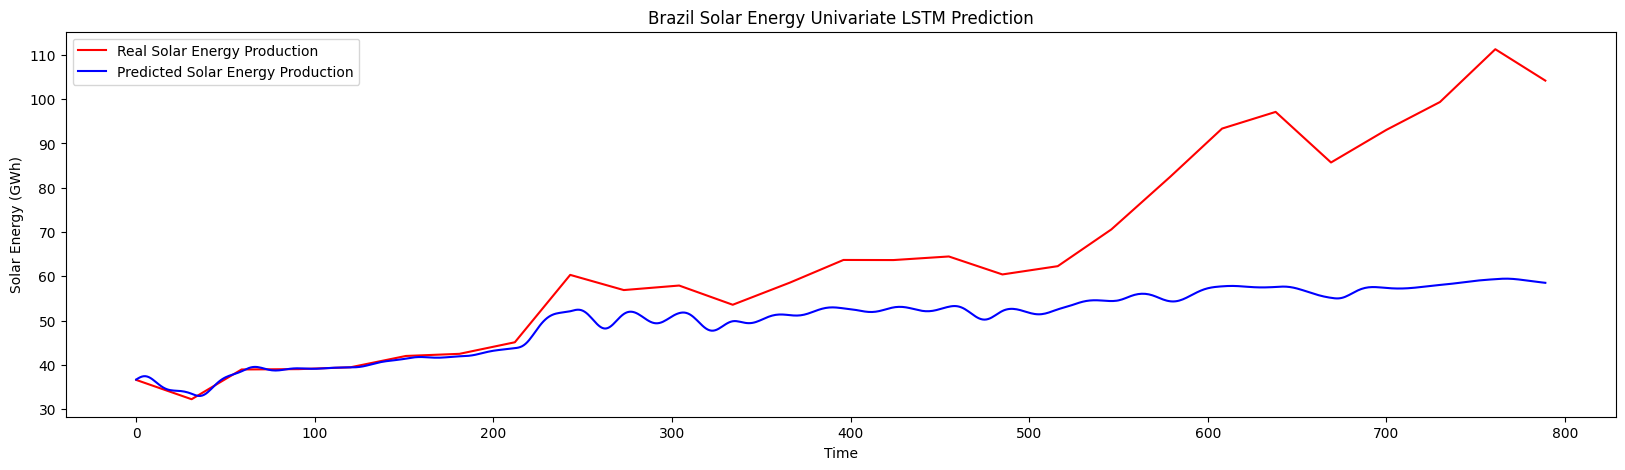

In [92]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Solar Energy Production')
plt.plot(uni_lstm_y_pred, color = 'blue', label = 'Predicted Solar Energy Production')
plt.title('Brazil Solar Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [93]:
data = solar_production_data['Brazil']

data.shape

(2982, 5)

In [94]:
X = data[['Daylight', 'Temperature', 'GHI', 'DNI', 'Value']]
y = data[['Value']]

X.head()

,Daylight,Temperature,GHI,DNI,Value
Date,,,,,
2015-01-01,760.447270,25.878698,842722.100000,562283.900000,0.084290
2015-01-02,760.007795,25.865683,840251.538710,559320.545161,0.084423
2015-01-03,759.568320,25.852668,837780.977419,556357.190323,0.084555
2015-01-04,759.128845,25.839653,835310.416129,553393.835484,0.084687
2015-01-05,758.689371,25.826638,832839.854839,550430.480645,0.084820


In [95]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [96]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [97]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(2193, 5)
(790, 5)

(2193, 1)
(790, 1)


In [98]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 365  # Define the number of previous time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 365 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

print(X_train1.shape)

(1828, 365, 5)


In [99]:
X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

In [55]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

brz_daily_multi_lstm = Sequential()
brz_daily_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
brz_daily_multi_lstm.add(Dropout(0.2))
brz_daily_multi_lstm.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
brz_daily_multi_lstm.add(Dropout(0.2))
brz_daily_multi_lstm.add(LSTM(units = 64))
brz_daily_multi_lstm.add(Dropout(0.2))
brz_daily_multi_lstm.add(Dense(1))

In [56]:
brz_daily_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

brz_daily_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
58/58 [==============================] - 153s 1s/step - loss: 0.0224
Epoch 2/100
58/58 [==============================] - 56s 970ms/step - loss: 0.0024
Epoch 3/100
58/58 [==============================] - 56s 967ms/step - loss: 0.0023
Epoch 4/100
58/58 [==============================] - 58s 1s/step - loss: 0.0022
Epoch 5/100
58/58 [==============================] - 56s 974ms/step - loss: 0.0022
Epoch 6/100
58/58 [==============================] - 57s 971ms/step - loss: 0.0021
Epoch 7/100
58/58 [==============================] - 56s 971ms/step - loss: 0.0019
Epoch 8/100
58/58 [==============================] - 61s 1s/step - loss: 0.0020
Epoch 9/100
58/58 [==============================] - 62s 1s/step - loss: 0.0016
Epoch 10/100
58/58 [==============================] - 64s 1s/step - loss: 0.0015
Epoch 11/100
58/58 [==============================] - 64s 1s/step - loss: 0.0014
Epoch 12/100
58/58 [==============================] - 67s 1s/step - loss: 0.0015
Epoch 13/100
58/58 [=

In [100]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 365:]
inputs = X_scaler.transform(inputs)
print(inputs.shape)
len(X_test)
X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))

multi_lstm_y_pred = brz_daily_multi_lstm.predict(X_test1)
multi_lstm_y_pred = y_scaler.inverse_transform(multi_lstm_y_pred)
real_value = y_scaler.inverse_transform(y_test)
hist_value = y_scaler.inverse_transform(y_train)
multi_lstm_y_pred

(1155, 5)
25/25 [==============================] - 13s 133ms/step


array([[35.33416 ],
       [35.544373],
       [35.74607 ],
       [35.932617],
       [36.097435],
       [36.23488 ],
       [36.340725],
       [36.411884],
       [36.44686 ],
       [36.445858],
       [36.409977],
       [36.341263],
       [36.24253 ],
       [36.11721 ],
       [35.969215],
       [35.802757],
       [35.622192],
       [35.43159 ],
       [35.234966],
       [35.036182],
       [34.838608],
       [34.645103],
       [34.457943],
       [34.27878 ],
       [34.10869 ],
       [33.94817 ],
       [33.797215],
       [33.6554  ],
       [33.521946],
       [33.395813],
       [33.275806],
       [33.160618],
       [33.04892 ],
       [32.94413 ],
       [32.85358 ],
       [32.784657],
       [32.743507],
       [32.734272],
       [32.758904],
       [32.817276],
       [32.907524],
       [33.026436],
       [33.16991 ],
       [33.333363],
       [33.512093],
       [33.70155 ],
       [33.89754 ],
       [34.096367],
       [34.294872],
       [34.490475],


In [101]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(multi_lstm_y_pred, real_value))
mse = mean_squared_error(multi_lstm_y_pred, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  28.2609799062949
Mean Squared Error:  1392.8842843373566
Root Mean Squared Error:  37.32136498491657


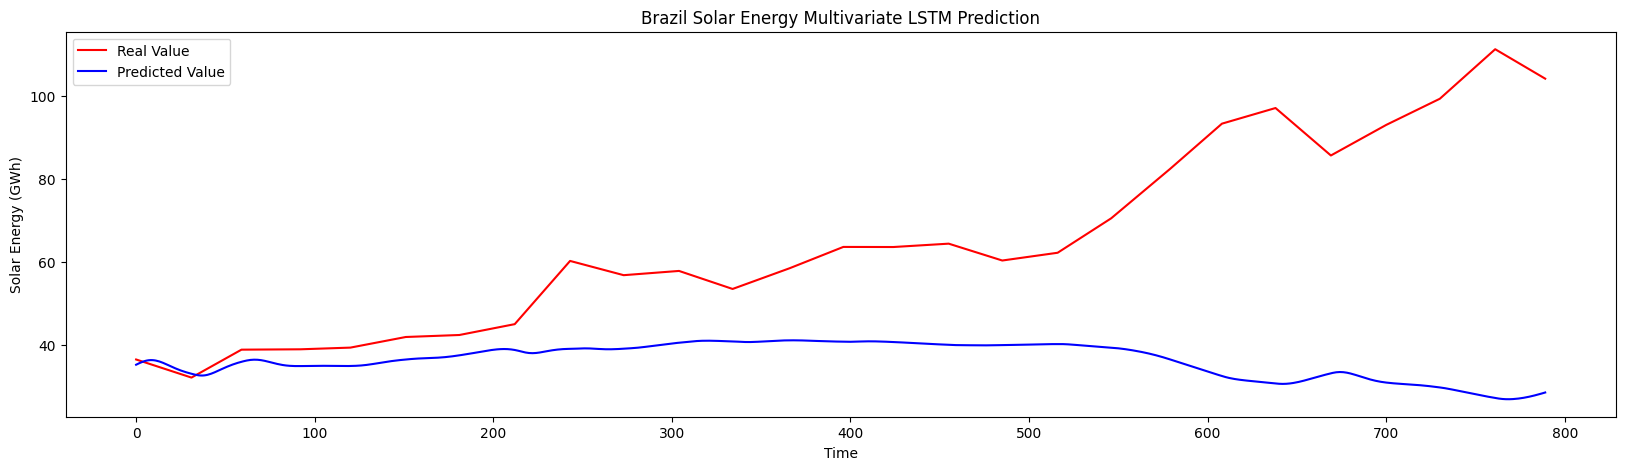

In [102]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(multi_lstm_y_pred, color='blue', label='Predicted Value')
plt.title('Brazil Solar Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

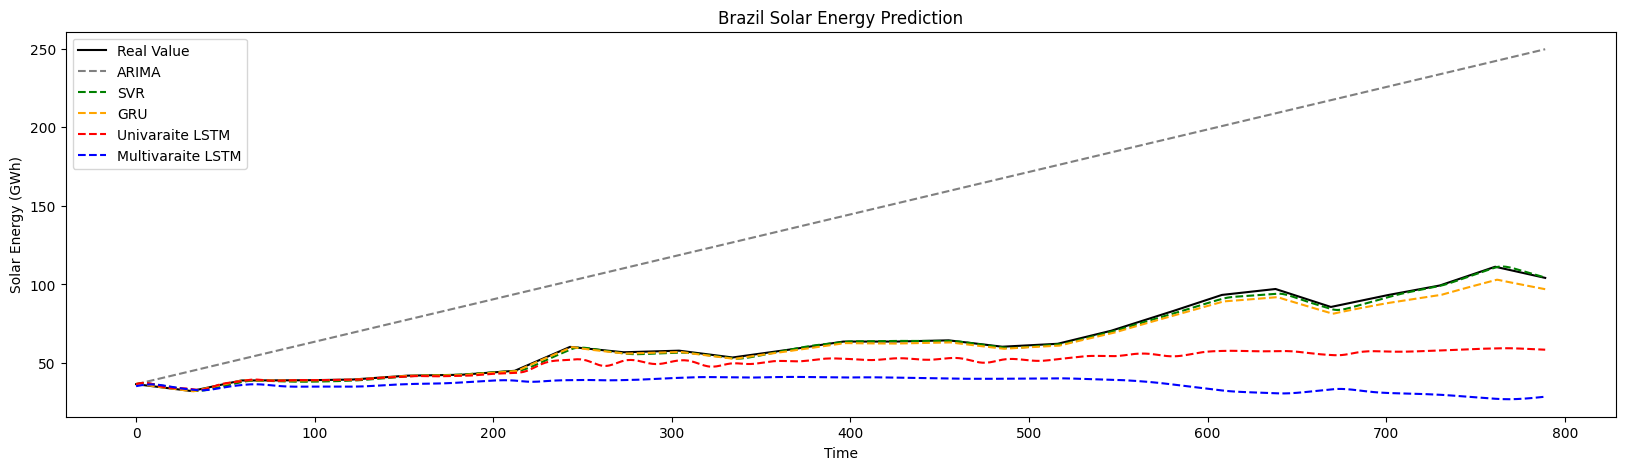

In [119]:
# Overview

# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='black', label='Real Value')
plt.plot(predictions.rx('mean')[0], color='grey', linestyle='--', label='ARIMA')
plt.plot(svr_y_pred, color='green', linestyle='--', label='SVR')
plt.plot(gru_y_pred, color='orange', linestyle='--', label='GRU')
plt.plot(uni_lstm_y_pred, color='red', linestyle='--', label='Univaraite LSTM')
plt.plot(multi_lstm_y_pred, color='blue', linestyle='--', label='Multivaraite LSTM')
plt.title('Brazil Solar Energy Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

# Save Best Model

In [60]:
brz_daily_gru.save("brz_solar_best_gru.h5")

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
